In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential , load_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
cd /content/gdrive/MyDrive

/content/gdrive/MyDrive


In [ ]:
import os
import shutil

# Define the path to the original dataset
data_path = '/content/gdrive/MyDrive/AICapstoneProjectData/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
# Define the path to the output directory
output_path = './dataset'

# Define the ratios for train/val/test splits
train_ratio = 0.8
test_ratio = 0.2

# Create the output directories if they do not exist
if not os.path.exists(output_path):
    os.makedirs(output_path)
for dir_name in ['train', 'test']:
    dir_path = os.path.join(output_path, dir_name)
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    for class_name in ['Cyst','Normal','Stone','Tumor']:
        class_path = os.path.join(dir_path, class_name)
        if not os.path.exists(class_path):
            os.makedirs(class_path)

# Loop over each class and copy files to train/val/test directories
for class_name in ['Cyst', 'Normal', 'Stone', 'Tumor']:
    class_path = os.path.join(data_path, class_name)
    files = os.listdir(class_path)
    num_files = len(files)
    num_train = int(num_files * train_ratio)
    num_test = num_files - num_train
    for i, file_name in enumerate(files):
        src_path = os.path.join(class_path, file_name)
        if i < num_train:
            dst_path = os.path.join(output_path, 'train', class_name, file_name)
        else:
            dst_path = os.path.join(output_path, 'test', class_name, file_name)
        shutil.copy(src_path, dst_path)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Define the data directories
train_dir = './dataset/train'
test_dir = './dataset/test'

# Define the data generator with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load the data and preprocess it with data augmentation
batch_size = 32
img_height = 224
img_width = 224
num_classes = 4

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Use the same validation data without data augmentation
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

train_data = train_generator[0][0]
train_labels = train_generator[0][1]
test_data = test_generator[0][0]
test_labels = test_generator[0][1]

# Define the CNN model with L2 regularization
model = Sequential()

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(img_height, img_width, 3), kernel_regularizer=l2(0.01)))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01)))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 100

history = model.fit(train_data, train_labels, epochs=100, validation_data=(train_data, train_labels), callbacks=[early_stopping])

Found 9955 images belonging to 4 classes.
Found 2492 images belonging to 4 classes.
Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 13.0210 - accuracy: 0.3125 - val_loss: 12.3408 - val_accuracy: 0.4062
Epoch 2/100
1/1 [==============================] - 0s 287ms/step - loss: 13.7536 - accuracy: 0.5000 - val_loss: 13.2633 - val_accuracy: 0.3750
Epoch 3/100
1/1 [==============================] - 1s 814ms/step - loss: 15.9367 - accuracy: 0.3438 - val_loss: 10.3343 - val_accuracy: 0.4375
Epoch 4/100
1/1 [==============================] - 1s 873ms/step - loss: 11.5300 - accuracy: 0.4062 - val_loss: 8.9551 - val_accuracy: 0.4062
Epoch 5/100
1/1 [==============================] - 1s 730ms/step - loss: 9.4952 - accuracy: 0.3438 - val_loss: 8.7417 - val_accuracy: 0.6562
Epoch 6/100
1/1 [==============================] - 0s 220ms/step - loss: 8.6669 - accuracy: 0.5938 - val_loss: 8.7955 - val_accuracy: 0.3750
Epoch 7/100
1/1 [==============================] - 0s 222ms/step -

In [ ]:
test_loss, test_acc = model.evaluate(test_data, test_labels)
print('Test accuracy:', test_acc)

1/1 [==============================] - 0s 81ms/step - loss: 3.5930 - accuracy: 0.4688
Test accuracy: 0.46875


In [ ]:
train_loss , train_acc = model.evaluate(train_data, train_labels)
print('Train accuracy:', train_acc*100)
print('Test accuracy:', test_acc*100)

1/1 [==============================] - 0s 67ms/step - loss: 1.1052 - accuracy: 1.0000
Train accuracy: 100.0
Test accuracy: 46.875


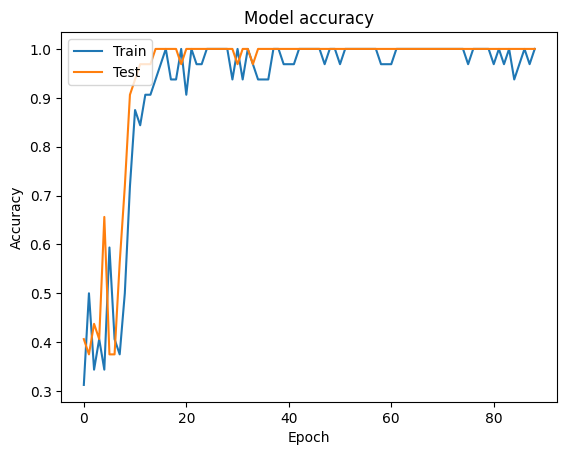

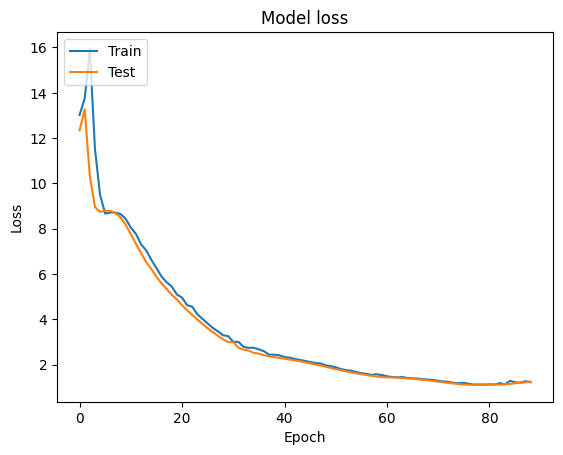

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()